In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

# 1. Import Dataset

In [2]:
from poc_data import PocDataset

NUM_CASES = 2**13
BATCH_SIZE = 2**5

poc_raw_dataset = PocDataset(num_cases=NUM_CASES)
data_loader = torch.utils.data.DataLoader(poc_raw_dataset, batch_size=BATCH_SIZE)
batch, event, time_to_event, _latent_variable = next(iter(data_loader))

print(batch.shape)
print(event.shape)
print(time_to_event.shape)
print(_latent_variable.shape)

torch.Size([32, 20, 3])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


### Data Exploration

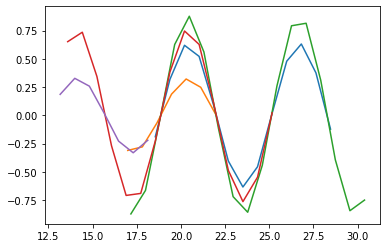

In [3]:
#Take a look at the longitudional data

plt.plot(np.array(batch[0][:int(time_to_event[0]),1]), batch[0][:int(time_to_event[0]),2])
plt.plot(np.array(batch[1][:int(time_to_event[1]),1]), batch[1][:int(time_to_event[1]),2])
plt.plot(np.array(batch[2][:int(time_to_event[2]),1]), batch[2][:int(time_to_event[2]),2])
plt.plot(np.array(batch[3][:int(time_to_event[3]),1]), batch[3][:int(time_to_event[3]),2])
plt.plot(np.array(batch[4][:int(time_to_event[4]),1]), batch[4][:int(time_to_event[4]),2])

### Test Sample

tensor([[ 0.0000, 14.1885,  0.7529],
        [ 0.0000, 15.0152,  0.4815],
        [ 0.0000, 15.8420, -0.1007],
        [ 0.0000, 16.6687, -0.6179],
        [ 0.0000, 17.4954, -0.7363],
        [ 0.0000, 18.3222, -0.3794],
        [ 0.0000, 19.1489,  0.2223],
        [ 0.0000, 19.9757,  0.6806],
        [ 0.0000, 20.8024,  0.6996],
        [ 0.0000, 21.6291,  0.2670]], device='cuda:0')
event=1, time_to_event=15, latent_variable=0.753941


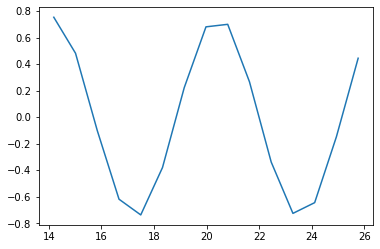

In [21]:
from poc_data import PocDataset

test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)
test_batch, test_event, test_time_to_event, test_latent_variable = next(iter(test_data_loader))
test_batch = test_batch.to(DEVICE)
test_event = test_event.to(DEVICE)
test_time_to_event = test_time_to_event.to(DEVICE)

plt.plot(np.array(test_batch.cpu()[0][:int(test_time_to_event[0]),1]), test_batch.cpu()[0][:int(test_time_to_event[0]),2])
print(test_batch[0,:10])
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))

# 2. Hyperparameters

In [5]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork, DynamicDeepHit
from losses import loss_1_batch, loss_2_batch, loss_3_batch

NUM_EPOCHS = 100

LEARNING_RATE_ENCODER = 0.0001
LEARNING_RATE_DECODER = 0.0001
LEARNING_RATE_CAUSESS = 0.00005

LOSS_1_AMPLIFIER = 1
LOSS_2_AMPLIFIER = 1
LOSS_3_AMPLIFIER = 1

RUN_VALIDATION_ROUND = True
VAL_NUM_CASES_RUNTIME = 2**5

input_size = 3
output_size = input_size
MAX_LENGTH = 20
NUM_CAUSES = 2
hidden_size_encoder = 512
hidden_size_attenti = 512
fc_size_encoder = 512
SIGMA = 1

# 3. Defining The Model

In [6]:
# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, hidden_size_attenti, output_size, MAX_LENGTH).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DDHT = DynamicDeepHit(encoder, decoder, causess, MAX_LENGTH, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)
 
# initialize loss
writer = SummaryWriter()

# 4. Training the model

In [7]:
# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for batch_number, data in enumerate(data_loader):

    batch_loss = 0

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()
    optimizer_causess.zero_grad()

    input_batch, event_batch, time_to_event_batch, _ = data
    input_batch = input_batch.to(DEVICE)
    event_batch = event_batch.to(DEVICE)
    time_to_event_batch = time_to_event_batch.to(DEVICE)

    output_batch, first_hitting_time_batch = DDHT(input_batch, time_to_event_batch)

    loss1 = loss_1_batch(first_hitting_time_batch, event_batch, time_to_event_batch, MAX_LENGTH)
    loss2 = loss_2_batch(first_hitting_time_batch, event_batch, time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)
    loss3 = loss_3_batch(output_batch, input_batch.detach())

    batch_loss = loss1 + loss2 + loss3

    batch_loss.backward()

    epoch_loss += batch_loss.detach()

    writer.add_scalar('train_loss1', loss1.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss2', loss2.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss3', loss3.item(), epoch*len(data_loader) + batch_number)

    optimizer_encoder.step()
    optimizer_decoder.step()
    optimizer_causess.step()

  if RUN_VALIDATION_ROUND:
    # validating round
    DDHT.eval()
    
    val_loss_1 = 0
    val_loss_3 = 0

    with torch.no_grad():
      val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES_RUNTIME)
      val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=VAL_NUM_CASES_RUNTIME)
      val_input_batch, val_event_batch, val_time_to_event_batch, _ = next(iter(val_data_loader))
      val_input_batch = val_input_batch.to(DEVICE)
      val_event_batch = val_event_batch.to(DEVICE)
      val_time_to_event_batch = val_time_to_event_batch.to(DEVICE)

      val_output_batch, val_first_hitting_time_batch = DDHT(val_input_batch, val_time_to_event_batch)

      val_loss1 = loss_1_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, MAX_LENGTH)/VAL_NUM_CASES_RUNTIME
      val_loss2 = loss_2_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME
      val_loss3 = loss_3_batch(val_output_batch, val_input_batch.detach())/VAL_NUM_CASES_RUNTIME

      writer.add_scalar('val_loss1', val_loss1.item(), epoch)
      writer.add_scalar('val_loss2', val_loss2.item(), epoch)
      writer.add_scalar('val_loss3', val_loss3.item(), epoch)
      writer.add_scalar('val_epoch_loss', val_loss1.item() + val_loss2.item() + val_loss3.item(), epoch)

    DDHT.train()
    # end validating round

  writer.add_scalar('train_epoch_loss', epoch_loss.item(), epoch)
  


100%|██████████| 100/100 [9:06:10<00:00, 327.70s/it]


# 4. Testing the Model

### Predicting the test sample

tensor([[19.3826, 10.8753,  0.1393],
        [22.4341, 16.2052,  0.0791],
        [24.0606, 17.9222,  0.0533],
        [24.4588, 18.3699,  0.0385],
        [24.5075, 18.4554,  0.0317],
        [24.5206, 18.5002,  0.0290],
        [24.6087, 18.6159,  0.0288],
        [24.8039, 18.8318,  0.0294],
        [25.0917, 19.1366,  0.0302],
        [25.4291, 19.4913,  0.0312]], device='cuda:0', grad_fn=<SliceBackward>)
event=1, time_to_event=15, latent_variable=0.753941


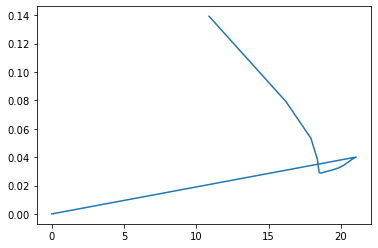

In [22]:
DDHT.eval()
test_encoder_output_vector, test_first_hitting_time = DDHT(test_batch, test_time_to_event)

plt.plot(np.array(test_encoder_output_vector.detach().cpu()[0][:,1]), test_encoder_output_vector.detach().cpu()[0][:,2])
print(test_encoder_output_vector[0,:10])
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))

(0.0, 1.0)

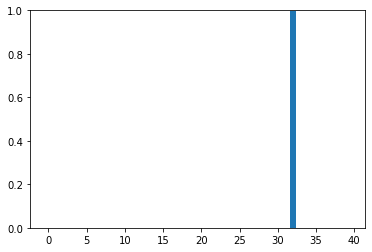

In [23]:
plt.bar([i for i in range(test_first_hitting_time.size(1))], test_first_hitting_time.squeeze().cpu().detach().numpy())
plt.ylim([0,1])

### Scoring our model

In [10]:
from poc_data import PocDataset

VAL_NUM_CASES = 2**6

val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES)
val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=2**6)
val_input_batch, val_event_batch, val_time_to_event_batch, _ = next(iter(val_data_loader))
val_input_batch = val_input_batch.to(DEVICE)
val_event_batch = val_event_batch.to(DEVICE)
val_time_to_event_batch = val_time_to_event_batch.to(DEVICE)


In [11]:
DDHT.eval()

val_output_batch, val_first_hitting_time_batch = DDHT(val_input_batch, val_time_to_event_batch)
val_loss1 = loss_1_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, MAX_LENGTH)/VAL_NUM_CASES
val_loss2 = loss_2_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES
val_loss3 = loss_3_batch(val_output_batch, val_input_batch.detach())/VAL_NUM_CASES


print("val_loss1=", val_loss1.item())
print("val_loss2=", val_loss2.item())
print("val_loss3=", val_loss3.item())


val_loss1= 3.585130214691162
val_loss2= 15.078988075256348
val_loss3= 7631.45654296875


Records:
val_loss1= 3.585130214691162
val_loss2= 15.078988075256348
val_loss3= 7631.45654296875

In [17]:
PATH = "C:/Users/marij/Desktop/DDHT/DDHT_pytorch/models/model_1.pth"
torch.save(DDHT.state_dict(), PATH)